In [316]:
import os
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import binary_dilation
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from skimage import io, filters, morphology, img_as_ubyte, img_as_uint
from skimage.filters import rank
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk
from skimage.feature import blob_dog, blob_log, blob_doh
import heapq

In [317]:
# Open the .ims file
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_1_2024-01-11_Confocal_01.00.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_2_2024-01-11_Confocal_01.16.28_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_3_2024-01-11_Confocal_01.08.43_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_1_2024-01-11_Confocal_01.23.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_2_2024-01-11_Confocal_01.30.50_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_3_2024-01-11_Confocal_01.40.34_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims'

# '/Users/moose/Downloads/Controls 20240418/WT DNase_2024-04-18_Confocal_00.55.19_DragonflyUser.ims'

# '/Users/moose/Downloads/Controls 20240418/WT 1 window_2024-04-18_Confocal_00.33.17_DragonflyUser_FusionStitcher.ims' Do not use!

# '/Users/moose/Downloads/Controls 20240418/WT 1 stack_2024-04-18_Confocal_00.48.57_DragonflyUser.ims'

In [318]:
file_name = '/Users/moose/Downloads/Controls 20240418/WT 1 stack_2024-04-18_Confocal_00.48.57_DragonflyUser.ims'
image = AICSImage(file_name)
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

In [319]:
DoG_thresh = 0.3
lowerbound = 2
search_mod = 25
z_project = 10

BlurToggle = False
gkernal = (21, 21)

DilateToggle = False
dstructure = np.ones((3, 3))

In [320]:
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

In [321]:
def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

In [322]:
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

In [323]:
background_collect = background_subtract(frame_mean)
peaks2, _ = find_peaks(background_collect, height = 1)
print(peaks2)

[247]


In [324]:
hist_key = {}

for i in range(peaks2[0]-search_mod, peaks2[0]):
    if i > 0:
        hist_key[i] = image_data[i]

for i in range(peaks2[0], peaks2[0]+search_mod+1):
    if i < len(image_data):
        hist_key[i] = image_data[i]

hist_stdev = {}
for i in hist_key.keys():
    hist_stdev[i] = np.std(hist_key[i])

hist_laplace = {}
hist_laplace_focusemeasure = {}
for i in hist_key.keys():
    hist_laplace[i] = cv2.Laplacian(hist_key[i], cv2.CV_64F)
    hist_laplace_focusemeasure[i] = np.var(hist_laplace[i])

hist_tenengrad_focusemeasure = {}
hist_squared_grad = {}
for i in hist_key.keys():
    sobelx = cv2.Sobel(hist_key[i], cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(hist_key[i], cv2.CV_64F, 0, 1, ksize=5)

    magnitude = np.sqrt(sobelx**2 + sobely**2)
    squared_grad = (sobelx**2 + sobely**2)

    hist_tenengrad_focusemeasure[i] = np.var(magnitude)
    hist_squared_grad[i] = np.var(squared_grad)


hist_brenner_focusemeasure = {}
for i in hist_key.keys():
    shifted_right = np.roll(hist_key[i], -1, axis=1)
    shifted_down = np.roll(hist_key[i], -1, axis=0)

    diff_right = (shifted_right - hist_key[i])[:-1, :-1] ** 2
    diff_down = (shifted_down - hist_key[i])[:-1, :-1] ** 2

    sum_diff = np.sum(diff_right) + np.sum(diff_down)
    hist_brenner_focusemeasure[i] = sum_diff

hist_max = {}
for i in hist_key.keys():
    hist_max[i] = np.max(hist_key[i])

In [325]:
print(f'Max Stdev: ' + str(np.max(list(hist_stdev.values()))) + ' at Frame ' + str(max(hist_stdev, key=hist_stdev.get)))
print(f'Max Laplace: ' + str(np.max(list(hist_laplace_focusemeasure.values())))+ ' at Frame ' + str(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get)))
print(f'Max Tenengrad: ' + str(np.max(list(hist_tenengrad_focusemeasure.values())))+ ' at Frame ' + str(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get)))
print(f'Max Squared Grad: ' + str(np.max(list(hist_squared_grad.values())))+ ' at Frame ' + str(max(hist_squared_grad, key=hist_squared_grad.get)))
print(f'Max Brenner: ' + str(np.max(list(hist_brenner_focusemeasure.values())))+ ' at Frame ' + str(max(hist_brenner_focusemeasure, key=hist_brenner_focusemeasure.get)))

Max Stdev: 119.22327726728481 at Frame 245
Max Laplace: 11323.331758709675 at Frame 245
Max Tenengrad: 7691358.698084442 at Frame 245
Max Squared Grad: 4157994611523513.0 at Frame 245
Max Brenner: 8959934518 at Frame 245


In [326]:
weight_mat = [1, 1, 1, 1, 1, 1]
focus_margins = []

# stdev_two_largest = heapq.nlargest(2, hist_stdev.values())
# laplace_two_largest = heapq.nlargest(2, hist_laplace_focusemeasure.values())
# tenengrad_two_largest = heapq.nlargest(2, hist_tenengrad_focusemeasure.values())

stdev_stdev = np.std(list(hist_stdev.values()))
laplace_stdev = np.std(list(hist_laplace_focusemeasure.values()))
tenengrad_stdev = np.std(list(hist_tenengrad_focusemeasure.values()))
squared_grad_stdev = np.std(list(hist_squared_grad.values()))
brenner_stdev = np.std(list(hist_brenner_focusemeasure.values()))


weight_mat[0] = stdev_stdev/np.mean(list(hist_stdev.values()))
weight_mat[1] = laplace_stdev/np.mean(list(hist_laplace_focusemeasure.values()))
weight_mat[2] = tenengrad_stdev/np.mean(list(hist_tenengrad_focusemeasure.values()))
weight_mat[3] = squared_grad_stdev/np.mean(list(hist_squared_grad.values()))
weight_mat[4] = brenner_stdev/np.mean(list(hist_brenner_focusemeasure.values()))

focus_ensemble = []
focus_ensemble.append(max(hist_stdev, key=hist_stdev.get))
focus_ensemble.append(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get))
focus_ensemble.append(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get))
focus_ensemble.append(max(hist_squared_grad, key=hist_squared_grad.get))
focus_ensemble.append(max(hist_brenner_focusemeasure, key=hist_brenner_focusemeasure.get))

voting_power = []
for i in range(len(focus_ensemble)):
    voting_power.append((focus_ensemble[i], weight_mat[i]))

vote = {}
for frame_num, weighted_vote in voting_power:
    if frame_num in vote:
        vote[frame_num] += weighted_vote

    else:
        vote[frame_num] = weighted_vote

In [327]:
voting_power

[(245, 0.21164537533982),
 (245, 0.4137603564942637),
 (245, 1.901886948707914),
 (245, 2.88254123578697),
 (245, 0.7155563977195565)]

In [328]:
mem_layer = max(vote, key=vote.get)

bud_test = []
for i in range(z_project):
    bud_test.append(mem_layer-i-1)

bud_test_img = []
for i in bud_test:
    bud_test_img.append(hist_key[i])

bud_composite = np.max(bud_test_img, axis=0)

bud_img = bud_composite
test_flat = subtractflatfield(bud_img)

normalized_img = (bud_img - np.min(bud_img)) / (np.max(bud_img) - np.min(bud_img))
np.clip(normalized_img, 0, 1, out=normalized_img)
normalized_img = img_as_ubyte(normalized_img)

norm_flat = (test_flat - np.min(test_flat)) / (np.max(test_flat) - np.min(test_flat))
np.clip(norm_flat, 0, 1, out=norm_flat)
norm_flat = img_as_ubyte(norm_flat)

bin_fac = np.std(norm_flat)/np.mean(norm_flat)
threshold_value = bin_fac*256
if BlurToggle == True:
    norm_flat = cv2.GaussianBlur(norm_flat, gkernal, 0, 0)
_, binary_image = cv2.threshold(norm_flat, threshold_value, 256, cv2.THRESH_BINARY)
if DilateToggle == True:
    binary_image = binary_dilation(binary_image, structure=dstructure)

In [329]:
bin_fac

0.2883454207185266

In [330]:
# plt.figure(dpi=150)
# plt.imshow(binary_image, cmap='gray')
# plt.axis('off')
# plt.show()

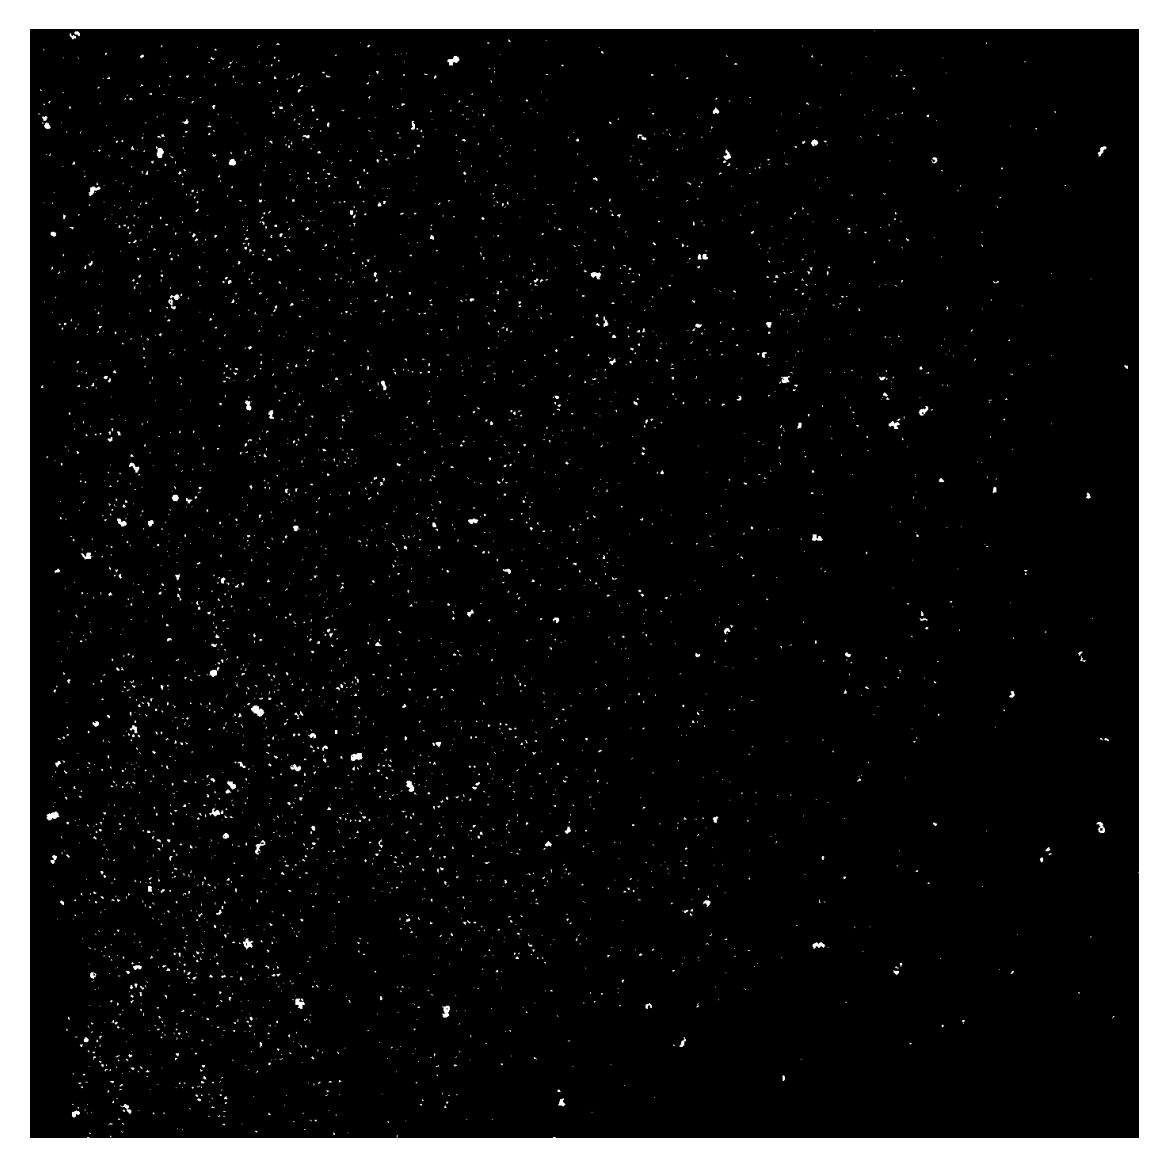

In [331]:
norm_thresh = np.percentile(norm_flat, 99)
norm_brightest = np.where(norm_flat > norm_thresh, 255, 0)

plt.figure(dpi=300)
plt.imshow(norm_brightest, cmap='gray')
plt.axis('off')
plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_binary.tif', dpi=500)
plt.show()

In [332]:
norm_thresh

47.0

In [333]:
np.max(norm_flat)

255

In [334]:
# plt.figure(dpi=150)
# plt.imshow(binary_image, cmap='gray')
# plt.axis('off')
# plt.show()

In [335]:
blobs_dog = blob_dog(norm_brightest, max_sigma=100, threshold=DoG_thresh)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
min_radius = lowerbound  # Minimum acceptable blob radius
max_radius = 100  # Maximum acceptable blob radius

blobs_dog = [blob for blob in blobs_dog if min_radius <= blob[2] <= max_radius]

In [336]:
# Another type of measurement
closed_im = morphology.closing(norm_brightest, morphology.square(1))
label_im = measure.label(closed_im)
region_im = measure.regionprops(label_im, intensity_image=norm_flat)
# for part in region_im:
#     print('Label: {} Area: {}'.format(part.label, part.area))

area_list = []
for part in region_im:
    area_list.append(part.area)

delete_small_components = filters.threshold_otsu(np.array(area_list)) 
area_list = [part for part in area_list if delete_small_components < part < 10000]


In [337]:
intensity_list = []
for part in region_im:
    intensity_list.append(part.mean_intensity)

int_cut = np.percentile(intensity_list, 50)
intensity_list = [part for part in intensity_list if  int_cut < part]

eccentricity_list = []
for part in region_im:
    eccentricity_list.append(part.eccentricity)

eccentricity_list = [part for part in eccentricity_list if 0.05 < part < 0.99]

# area_list_thresh = np.percentile(area_list, 98)
mean_comp = np.percentile(intensity_list, 95)
lower_ecc = np.percentile(eccentricity_list, 5)
higher_ecc = np.percentile(eccentricity_list, 95)

# filter_area_low = area_list_thresh 
filter_eccentricity_low = lower_ecc
filter_eccentricity_high = higher_ecc
# region_im_filtered = [part for part in region_im if filter_area_low < part.area < 10000]
region_im_filtered = [part for part in region_im if filter_eccentricity_low < part.eccentricity < filter_eccentricity_high]
region_im_filtered = [part for part in region_im_filtered if part.mean_intensity > mean_comp]

print('Raw Regions: {}'.format(len(region_im)))
print('Filtered Regions: {}'.format(len(region_im_filtered)))
for part in region_im_filtered:
    print('Centroid: ({:.0f}, {:.0f}) | Area: {} | Eccentricity {:.2f} | Mean Intensity {:.2f}'.format(part.centroid[0], part.centroid[1], part.area, part.eccentricity, part.mean_intensity))

Raw Regions: 3815
Filtered Regions: 79
Centroid: (39, 534) | Area: 103.0 | Eccentricity 0.85 | Mean Intensity 88.62
Centroid: (122, 21) | Area: 46.0 | Eccentricity 0.60 | Mean Intensity 90.00
Centroid: (156, 164) | Area: 92.0 | Eccentricity 0.79 | Mean Intensity 72.89
Centroid: (153, 1353) | Area: 63.0 | Eccentricity 0.94 | Mean Intensity 71.08
Centroid: (159, 880) | Area: 64.0 | Eccentricity 0.73 | Mean Intensity 78.11
Centroid: (203, 80) | Area: 85.0 | Eccentricity 0.87 | Mean Intensity 69.14
Centroid: (231, 406) | Area: 22.0 | Eccentricity 0.74 | Mean Intensity 71.18
Centroid: (263, 507) | Area: 22.0 | Eccentricity 0.63 | Mean Intensity 69.18
Centroid: (287, 845) | Area: 26.0 | Eccentricity 0.79 | Mean Intensity 73.04
Centroid: (287, 852) | Area: 38.0 | Eccentricity 0.62 | Mean Intensity 73.84
Centroid: (310, 714) | Area: 78.0 | Eccentricity 0.82 | Mean Intensity 97.18
Centroid: (319, 252) | Area: 17.0 | Eccentricity 0.71 | Mean Intensity 71.00
Centroid: (341, 557) | Area: 17.0 | Ec

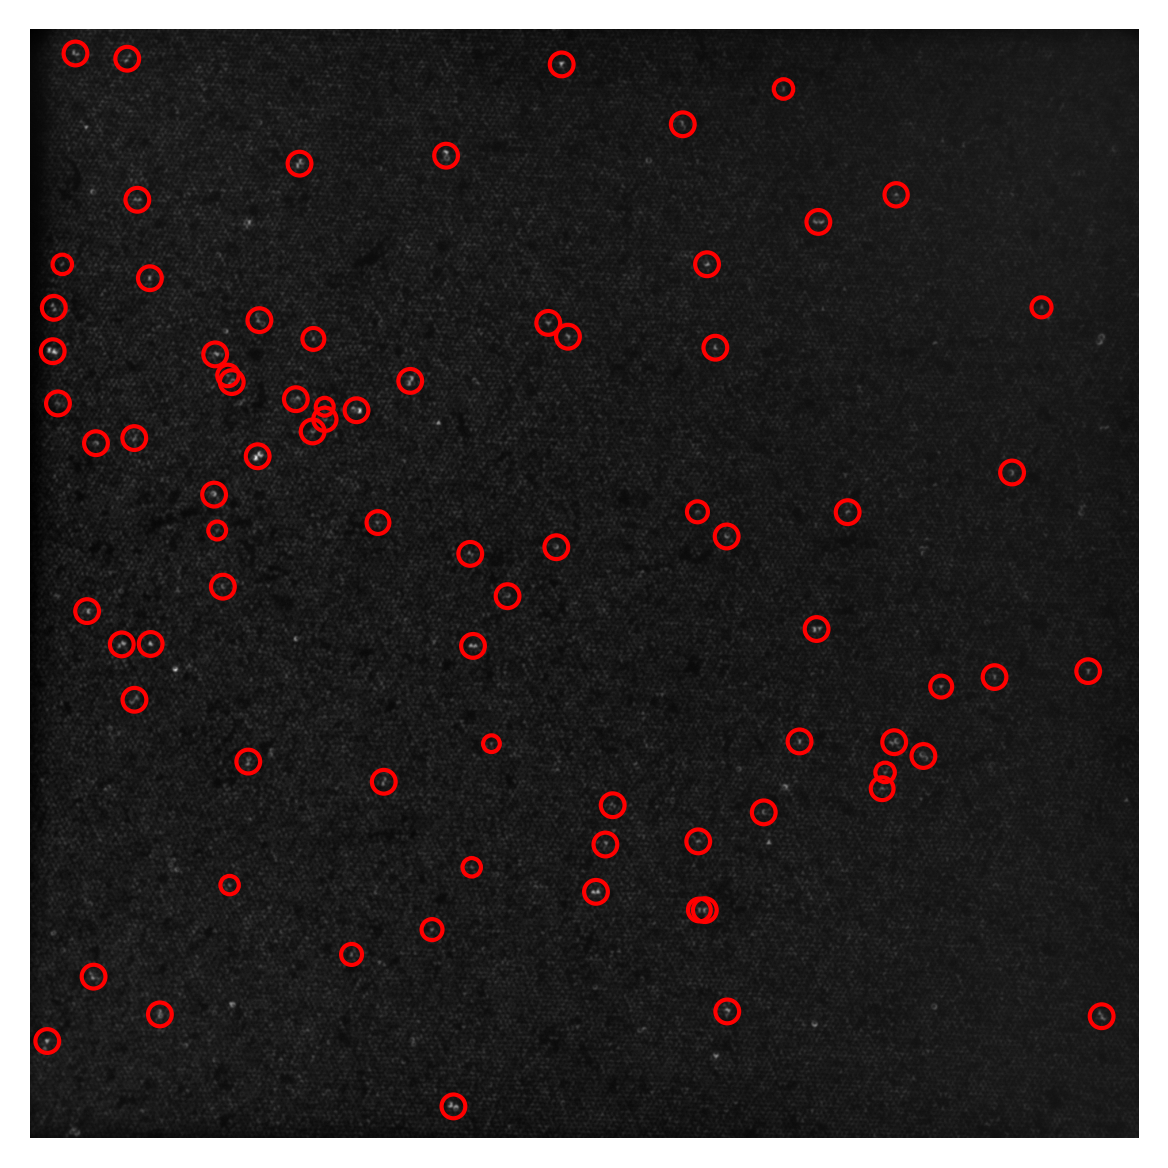

In [338]:
fig_alt, ax_alt = plt.subplots(dpi=300)
ax_alt.imshow(norm_flat, cmap='gray')
for region in region_im_filtered:
    y, x = region.centroid
    radius = np.sqrt(region.area / np.pi)

    circle = plt.Circle((x, y), np.where(radius*5 < 15, radius*5, 15), fill=False, edgecolor='red')
    ax_alt.add_patch(circle)
   
ax_alt.invert_yaxis()
plt.axis('off')
plt.show()

In [352]:
imsave(f'/Users/moose/Desktop/trace_ca-local/'+ os.path.splitext(os.path.basename(file_name))[0] + 'test_flat.tif', test_flat)

In [348]:
os.mkdir(f'/Users/moose/Desktop/trace_ca-local/Train_Images/' + os.path.splitext(os.path.basename(file_name))[0])
for i, part in enumerate(region_im_filtered):
    minr, minc, maxr, maxc = part.bbox
    region_image = norm_flat[minr:maxr, minc:maxc]
    imsave(f'/Users/moose/Desktop/trace_ca-local/Train_Images/'+ os.path.splitext(os.path.basename(file_name))[0] +'/region_' + str(i) + '.png', region_image)

In [340]:
for part in region_im_filtered:
    print('({:.0f}, {:.0f}, {:.0f}, {:.0f})'.format(part.bbox[0], part.bbox[1], part.bbox[2], part.bbox[3]))

(34, 527, 46, 542)
(118, 18, 126, 26)
(148, 159, 163, 169)
(148, 1348, 161, 1359)
(152, 875, 165, 885)
(199, 74, 211, 89)
(229, 404, 235, 408)
(260, 505, 266, 510)
(284, 843, 291, 848)
(284, 849, 291, 856)
(307, 708, 316, 721)
(317, 250, 322, 255)
(340, 555, 344, 561)
(363, 724, 376, 730)
(372, 840, 377, 848)
(408, 924, 415, 930)
(416, 731, 424, 740)
(439, 1072, 444, 1080)
(444, 443, 456, 450)
(459, 1077, 464, 1083)
(469, 271, 482, 280)
(476, 1122, 488, 1134)
(495, 581, 500, 585)
(495, 1084, 505, 1098)
(497, 969, 505, 974)
(547, 125, 560, 138)
(567, 1147, 572, 1154)
(578, 1215, 586, 1220)
(585, 1333, 593, 1339)
(618, 110, 628, 122)
(618, 553, 625, 566)
(620, 149, 628, 156)
(638, 987, 646, 1001)
(661, 64, 670, 78)
(681, 597, 688, 607)
(692, 241, 700, 247)
(733, 552, 742, 560)
(743, 660, 750, 668)
(756, 876, 764, 884)
(764, 234, 769, 239)
(774, 436, 779, 444)
(787, 1029, 793, 1036)
(788, 840, 793, 846)
(805, 226, 818, 239)
(836, 1236, 844, 1243)
(854, 279, 868, 296)
(874, 79, 881, 87)
(8

In [341]:
# print(f'File Name: ' + os.path.basename(file_name))
# bud_df = pd.DataFrame(blobs_dog, columns=['y-coord', 'x-coord', 'Radius'])
# bud_df.index.name = 'Bud ID'
# vote_array = [[k, v] for k, v in vote.items()]
# vote_df = pd.DataFrame(vote_array, columns=['Stack Layer', 'Vote Weight'])
# print(f'Membrane layer at: ' + str(mem_layer))
# print(f'Budding layer at: ' + str(bud_test[0]))
# print(f'Number of Detected Budding Events: ' + str(len(blobs_dog)))
# print('------------------------------')
# print('Final Vote Tally:')
# print(vote_df.to_string(index=False))
# print('------------------------------')
# print(bud_df)

In [342]:
# # Convert pandas dataframes and other variables to string and format it for display via matplotlb
# bud_df_str = bud_df.to_string()
# vote_df_str = vote_df.to_string(index=False)
# text = f"""File Name: {os.path.basename(file_name)}
# Membrane layer at: {mem_layer}
# Budding layer at: {bud_test[0]}
# Number of Detected Budding Events: {len(blobs_dog)}
# ------------------------------
# Final Vote Tally:
# {vote_df_str}
# ------------------------------
# {bud_df_str}"""

# fig = plt.figure(figsize=(9, 4))
# plt.text(0, 1, text, fontsize=12, verticalalignment='top')
# plt.axis('off')
# # plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_stats.png', dpi=500)
# plt.show()


# fig, ax = plt.subplots(figsize=(3, 3), dpi=500)
# ax.set_title('Detected Budding Events')
# ax.imshow(norm_flat, cmap='gray')
# for blob in blobs_dog:
#     y, x, r = blob
#     c = plt.Circle((x, y), r, color='green', linewidth=2, fill=False)
#     ax.add_patch(c)
#     ax.invert_yaxis()  # Invert the y-axis
# ax.set_axis_off()

# # plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_detected.png', dpi=500)
# plt.show()